In [16]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import argparse
import numpy as np
import math
import cv2
import scipy.misc

In [17]:
# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        self.deconv1_2 = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(input)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))
        # x = F.relu(self.deconv4_bn(self.deconv4(x)))
        # x = F.tanh(self.deconv5(x))

        return x

class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1_1 = nn.Conv2d(1, d//2, 4, 2, 1)
        self.conv1_2 = nn.Conv2d(10, d//2, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d * 4, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))

        return x

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

root = 'MNIST_cDCGAN_eval_results'

In [18]:
# fixed noise & label
temp_z_ = torch.randn(100, 100)

fixed_z_ = temp_z_
fixed_y_ = torch.ones(100, 1)

fixed_z_ = fixed_z_.view(-1, 100, 1, 1)
fixed_y_label_ = torch.zeros(100, 10)
fixed_y_label_.scatter_(1, fixed_y_.type(torch.LongTensor), 1)
fixed_y_label_ = fixed_y_label_.view(-1, 10, 1, 1)

fixed_z_, fixed_y_label_ = Variable(fixed_z_.cuda(), volatile=True), Variable(fixed_y_label_.cuda(), volatile=True)

/home/zwu/miniconda3/envs/pytorch-py35/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if sys.path[0] == '':


In [19]:
def compute_orientation(img, plot=False):
    img = np.asarray(img).reshape([32,32])
    #print(np.max(img))
    #print(np.min(img))
    y, x = np.nonzero(img)
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]
    if plot:
        scale = 20
        plt.plot([x_v1*-scale*2, x_v1*scale*2],
             [y_v1*-scale*2, y_v1*scale*2], color='red')
        plt.plot([x_v2*-scale, x_v2*scale],
             [y_v2*-scale, y_v2*scale], color='blue')
        plt.plot(x, y, 'k.')
        plt.axis('equal')
        plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()
    return np.arctan((x_v1)/(y_v1)) * 180 / math.pi

In [20]:
def show_result(num_epoch, path = 'result.png'):

    G.eval()
    test_images = G(fixed_z_, fixed_y_label_)
    G.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)


In [21]:
def undesired_objects(image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    img2 = np.zeros(output.shape)
    img2[output == max_label] = 255
    return img2
    #cv2.imshow("Biggest component", img2)
    #cv2.waitKey()
    
def show_result_ploting_images(num_epoch, save = False):

    G.eval()
    test_images = G(fixed_z_, fixed_y_label_)
    G.train()

    import scipy.misc
    for k in range(10*10):
        #scipy.misc.imsave('MNIST_cDCGAN_eval_results/{}.png'.format(k), test_images[k, 0].cpu().data.numpy())
        im = test_images[k, 0].cpu().data.numpy()
        im = np.add(im, np.ones(im.shape))
        im = im * 127.5
        im = im.astype(np.uint8)
        im = undesired_objects(im)
        print(compute_orientation(im, plot=True))
        scipy.misc.imsave('MNIST_cDCGAN_eval_results/{}.png'.format(k), im)

In [25]:
# fixed noise & label
def get_orientation_number(number, size, remove_tilted=False, remove_untilted=False):
    theta_lst = []
    if remove_tilted:
        G.load_state_dict(torch.load('MNIST_cDCGAN_results/remove_tilt_untilt/remove_tilted_1_balanced/MNIST_cDCGAN_generator_param.pkl'))
        path = os.path.join('MNIST_cDCGAN_eval_results/remove_tilted_1_balanced', str(number))
        if not os.path.isdir(path):
            os.makedirs(path)
        print('MNIST_cDCGAN_results/remove_tilt_untilt/remove_tilted_1_balanced/MNIST_cDCGAN_generator_param.pkl')
    elif remove_untilted:
        G.load_state_dict(torch.load('MNIST_cDCGAN_results/remove_tilt_untilt/remove_untilted_1_balanced/MNIST_cDCGAN_generator_param.pkl'))
        path = os.path.join('MNIST_cDCGAN_eval_results/remove_untilted_1_balanced', str(number))
        if not os.path.isdir(path):
            os.makedirs(path)
        print('MNIST_cDCGAN_results/remove_tilt_untilt/remove_untilted_1_balanced/MNIST_cDCGAN_generator_param.pkl')
    elif not remove_tilted and not remove_untilted:
        G.load_state_dict(torch.load('MNIST_cDCGAN_results/data/MNIST_cDCGAN_generator_param.pkl'))
        path = os.path.join('MNIST_cDCGAN_eval_results/whole_dataset', str(number))
        if not os.path.isdir(path):
            os.makedirs(path)
        print('MNIST_cDCGAN_results/data/MNIST_cDCGAN_generator_param.pkl')
    
    G.eval()
    
    while size / 100 > 0:
        temp_z_ = torch.randn(100, 100)
        fixed_z_ = temp_z_
        fixed_y_ = torch.ones(100, 1) * number
        fixed_z_ = fixed_z_.view(-1, 100, 1, 1)
        fixed_y_label_ = torch.zeros(100, 10)
        fixed_y_label_.scatter_(1, fixed_y_.type(torch.LongTensor), 1)
        #print(fixed_y_label_)
        fixed_y_label_ = fixed_y_label_.view(-1, 10, 1, 1)
        fixed_z_, fixed_y_label_ = Variable(fixed_z_.cuda(), volatile=True), Variable(fixed_y_label_.cuda(), volatile=True)
        test_images = G(fixed_z_, fixed_y_label_)
        for k in range(100):
            im = test_images[k, 0].cpu().data.numpy()
            im = np.add(im, np.ones(im.shape))
            im = im * 127.5
            im = im.astype(np.uint8)
            im = undesired_objects(im)
            theta = compute_orientation(im, plot=False)
            theta_lst.append(theta)
            scipy.misc.imsave(os.path.join(path, '{}.png'.format(size-k)), im)
        size = size - 100
    
    return theta_lst

/home/zwu/miniconda3/envs/pytorch-py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


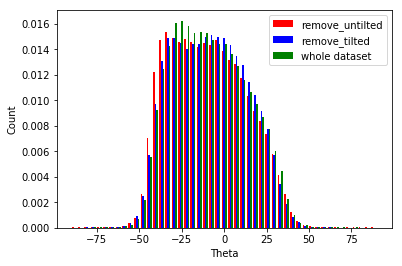

In [33]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#plt.style.use('seaborn-deep')
bins = np.linspace(-90, 90, 50)


In [26]:
for number in [0,1,2,3,4,5,6,7,8,9]:
    theta_lst_remove_tilted = get_orientation_number(number, 5000, remove_tilted=True, remove_untilted=False)
    theta_lst_remove_untilted = get_orientation_number(number, 5000, remove_tilted=False, remove_untilted=True)
    theta_lst_whole = get_orientation_number(number, 5000, remove_tilted=False, remove_untilted=False)
#     plt.hist([theta_lst_remove_untilted, theta_lst_remove_tilted, theta_lst_whole], normed=True, bins=bins, color=['r', 'b', 'g'], label=['remove_untilted','remove_tilted', 'whole dataset'])
#     plt.legend(loc='upper right')
#     plt.ylabel('Count');
#     plt.xlabel('Theta')
#     plt.savefig('number%d' % number, dpi=300)

MNIST_cDCGAN_results/remove_tilt_untilt/remove_tilted_1_balanced/MNIST_cDCGAN_generator_param.pkl


/home/zwu/miniconda3/envs/pytorch-py35/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/home/zwu/miniconda3/envs/pytorch-py35/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/zwu/miniconda3/envs/pytorch-py35/lib/python3.5/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


MNIST_cDCGAN_results/remove_tilt_untilt/remove_untilted_1_balanced/MNIST_cDCGAN_generator_param.pkl
MNIST_cDCGAN_results/data/MNIST_cDCGAN_generator_param.pkl
MNIST_cDCGAN_results/remove_tilt_untilt/remove_tilted_1_balanced/MNIST_cDCGAN_generator_param.pkl
MNIST_cDCGAN_results/remove_tilt_untilt/remove_untilted_1_balanced/MNIST_cDCGAN_generator_param.pkl
MNIST_cDCGAN_results/data/MNIST_cDCGAN_generator_param.pkl
MNIST_cDCGAN_results/remove_tilt_untilt/remove_tilted_1_balanced/MNIST_cDCGAN_generator_param.pkl
MNIST_cDCGAN_results/remove_tilt_untilt/remove_untilted_1_balanced/MNIST_cDCGAN_generator_param.pkl
MNIST_cDCGAN_results/data/MNIST_cDCGAN_generator_param.pkl
MNIST_cDCGAN_results/remove_tilt_untilt/remove_tilted_1_balanced/MNIST_cDCGAN_generator_param.pkl
MNIST_cDCGAN_results/remove_tilt_untilt/remove_untilted_1_balanced/MNIST_cDCGAN_generator_param.pkl
MNIST_cDCGAN_results/data/MNIST_cDCGAN_generator_param.pkl
MNIST_cDCGAN_results/remove_tilt_untilt/remove_tilted_1_balanced/MNIST

In [23]:
# training parameters
batch_size = 128
lr = 0.0002
train_epoch = 20

# data_loader
img_size = 32
transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('flip_data_0_all', train=True, download=False, transform=transform),
#     batch_size=batch_size, shuffle=True)

# network
G = generator(128)
G.weight_init(mean=0.0, std=0.02)
G.cuda()
#G.load_state_dict(torch.load('MNIST_cDCGAN_results/remove_tilt_untilt/remove_tilted_1_balanced/MNIST_cDCGAN_generator_param.pkl'))
# results save folder
#root = 'MNIST_cDCGAN_results/'
model = 'MNIST_cDCGAN_'
if not os.path.isdir(root):
    os.makedirs(root)
if not os.path.isdir(os.path.join(root, 'Fixed_results')):
    os.mkdir(os.path.join(root, 'Fixed_results'))

/home/zwu/miniconda3/envs/pytorch-py35/lib/python3.5/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


255.0
0.0


/home/zwu/miniconda3/envs/pytorch-py35/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


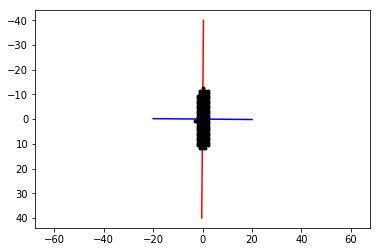

/home/zwu/miniconda3/envs/pytorch-py35/lib/python3.5/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


-0.5034539376938882
255.0
0.0


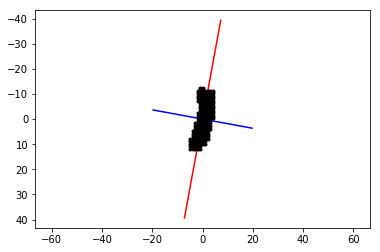

-10.413631718810697
255.0
0.0


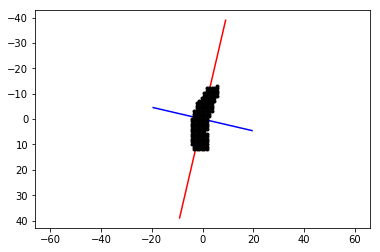

-13.102956277416792
255.0
0.0


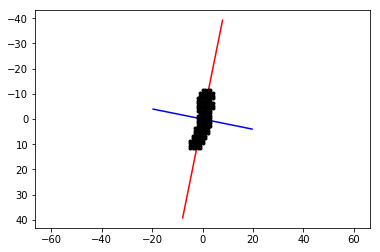

-11.409322569378595
255.0
0.0


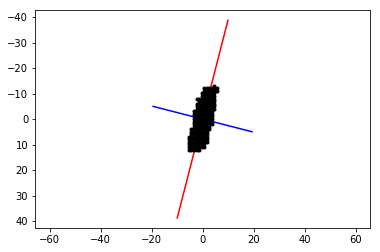

-14.387060359223254
255.0
0.0


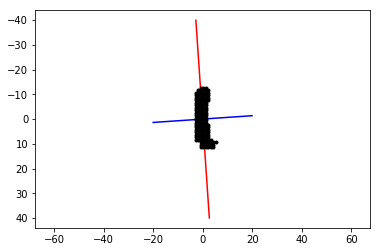

3.8954850304850726
255.0
0.0


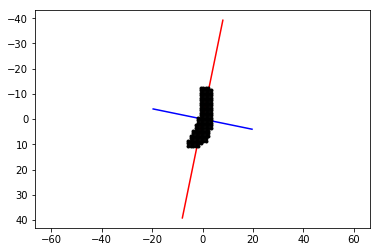

-11.577084551589893
255.0
0.0


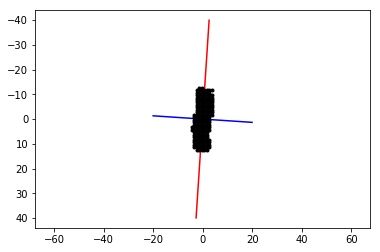

-3.772984725023948
255.0
0.0


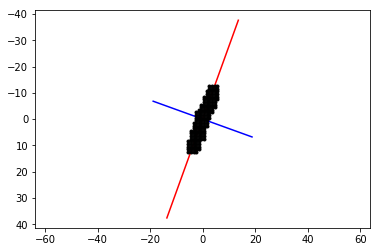

-19.86836028122053
255.0
0.0


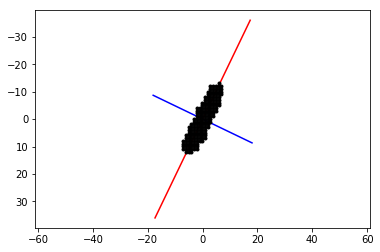

-25.70787038933877
255.0
0.0


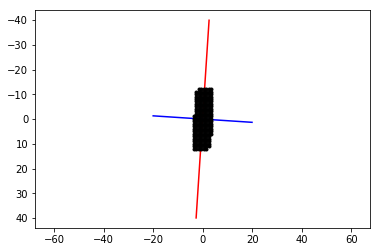

-3.746074927479199
255.0
0.0


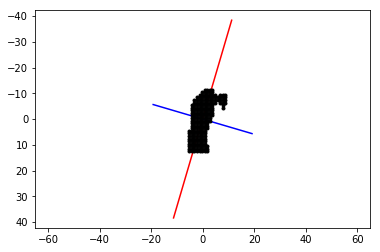

-16.3823316746346
255.0
0.0


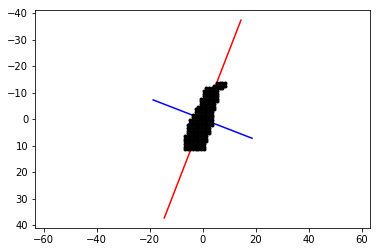

-21.19525707658437
255.0
0.0


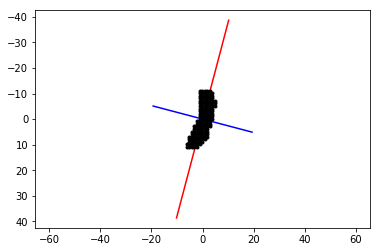

-14.774137268514057
255.0
0.0


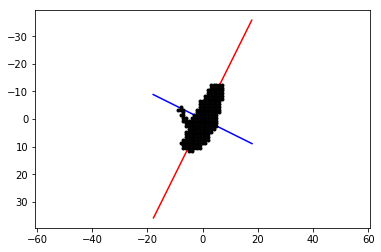

-26.426063573600434
255.0
0.0


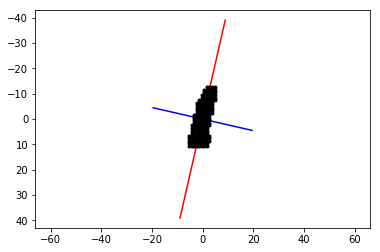

-12.872805931284331
255.0
0.0


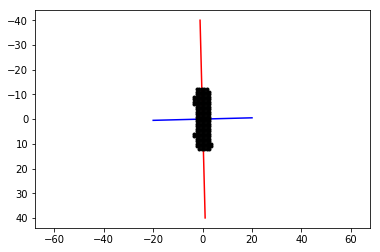

1.47072711032339
255.0
0.0


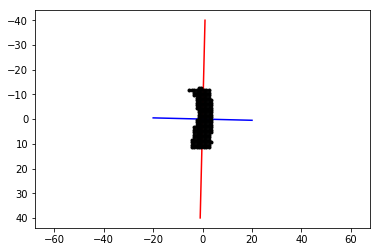

-1.3920797321797063
255.0
0.0


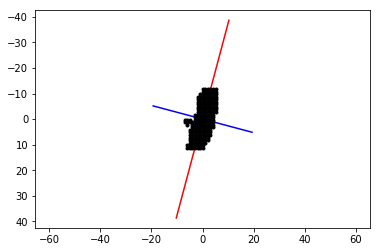

-14.903711668686313
255.0
0.0


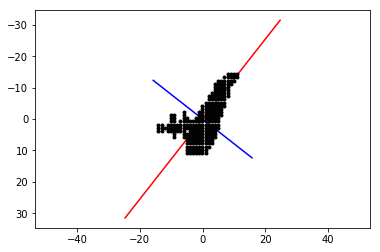

-38.10300188399136
255.0
0.0


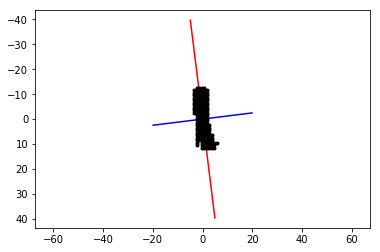

7.076662866304496
255.0
0.0


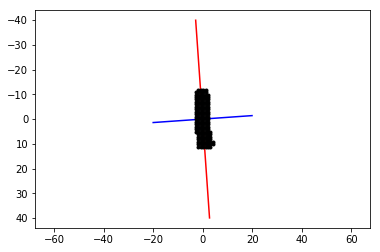

4.0090199340926365
255.0
0.0


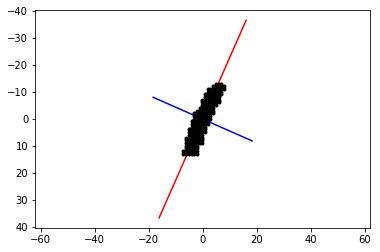

-23.769674661869786
255.0
0.0


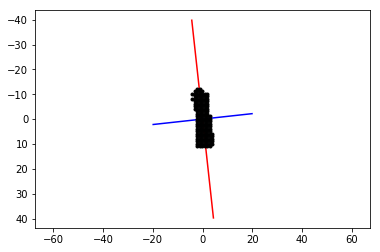

6.248646948906513
255.0
0.0


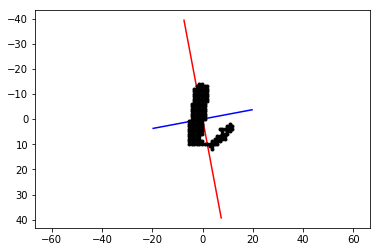

10.65910578292376
255.0
0.0


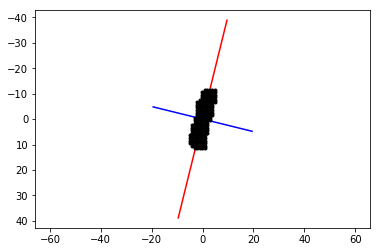

-13.849611564357245
255.0
0.0


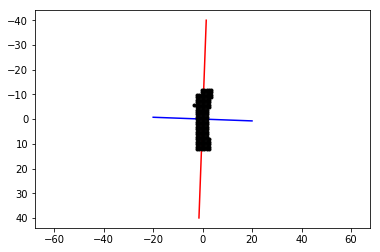

-2.1100629775626536
255.0
0.0


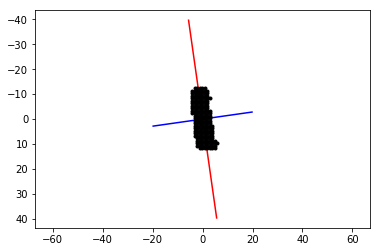

8.08634383258221
255.0
0.0


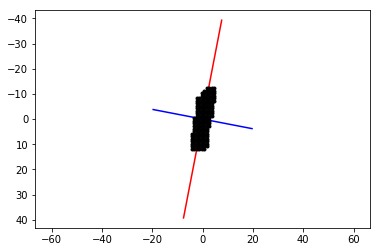

-10.925016552476162
255.0
0.0


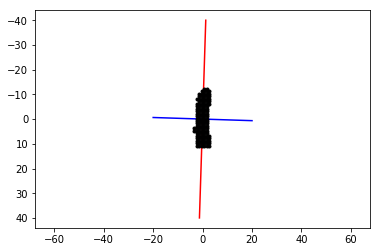

-1.8297672745713418
255.0
0.0


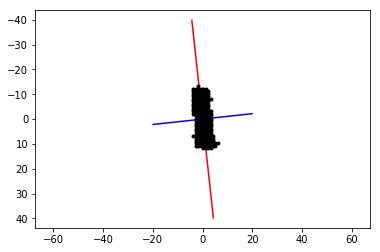

6.20961616229967
255.0
0.0


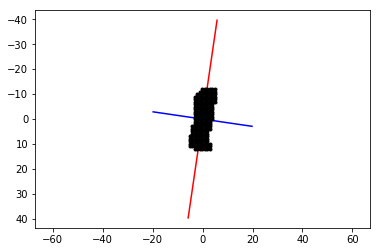

-8.313389995692015
255.0
0.0


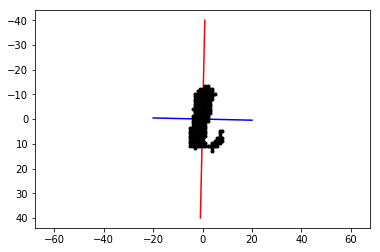

-1.283162162632899
255.0
0.0


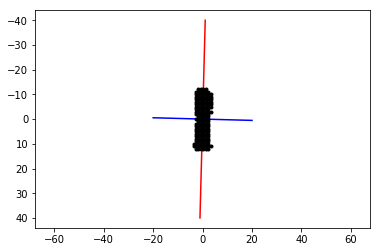

-1.5219957937348905
255.0
0.0


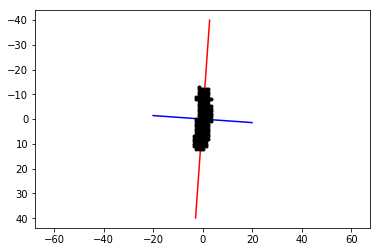

-4.066057475542497
255.0
0.0


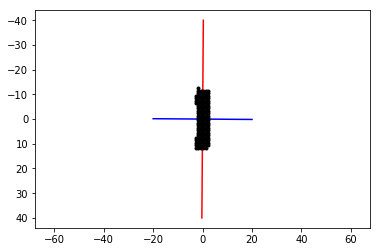

-0.4313223722041228
255.0
0.0


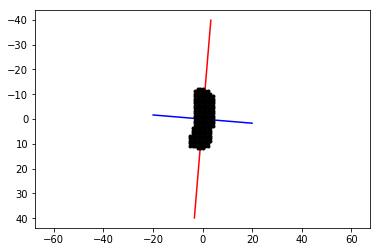

-4.750238376185574
255.0
0.0


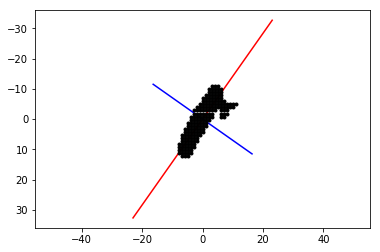

-35.1492510032928
255.0
0.0


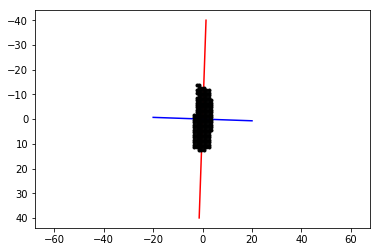

-1.9792989376036867
255.0
0.0


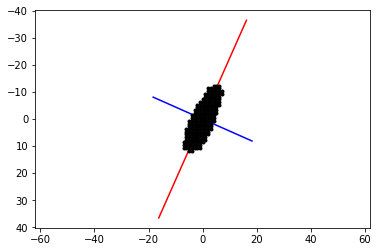

-23.92888205633327
255.0
0.0


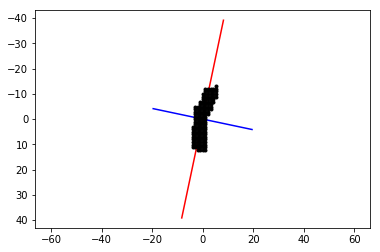

-11.911780236816995
255.0
0.0


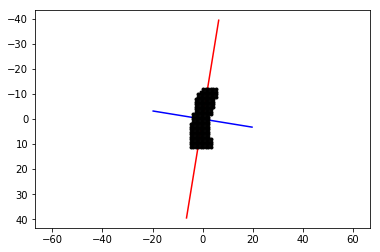

-9.245846890269814
255.0
0.0


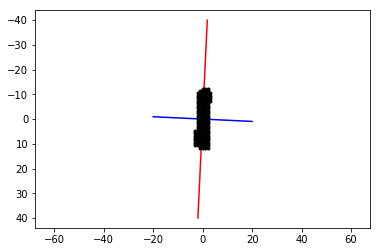

-2.721861800182427
255.0
0.0


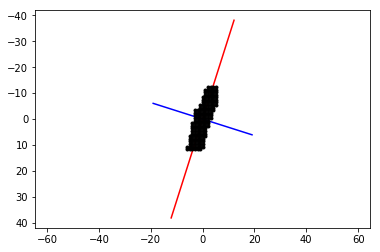

-17.636682200972924
255.0
0.0


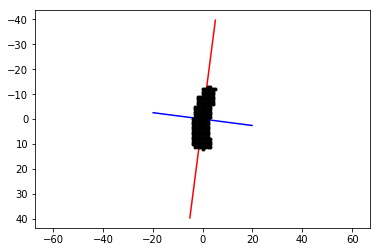

-7.353739549266469
255.0
0.0


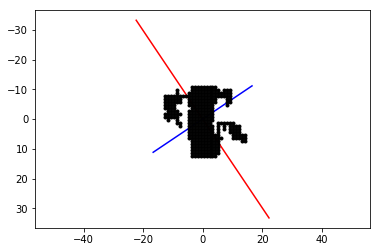

33.892934959460504
255.0
0.0


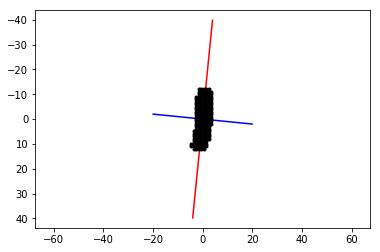

-5.722313433596753
255.0
0.0


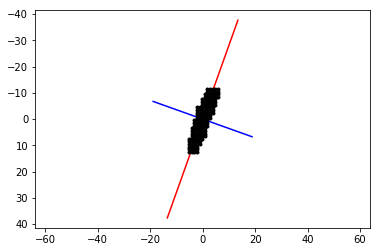

-19.640195597047313
255.0
0.0


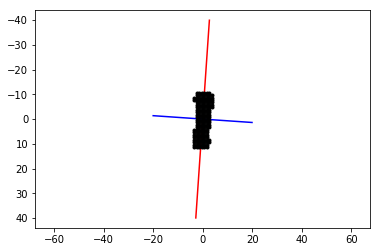

-3.929560901107177
255.0
0.0


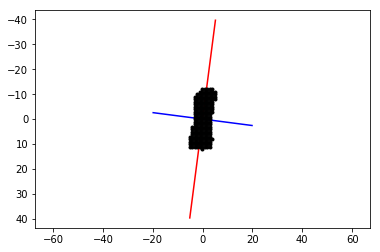

-7.393105225474404
255.0
0.0


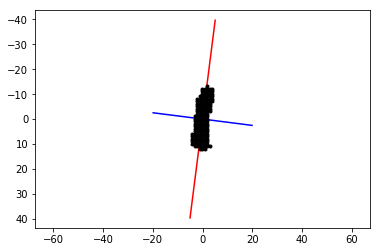

-7.250962774472944
255.0
0.0


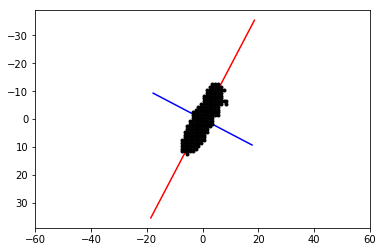

-27.661531800900946
255.0
0.0


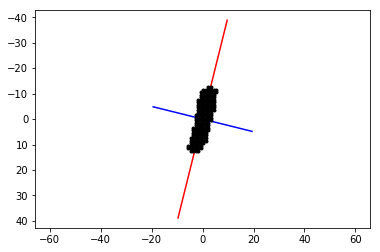

-13.96082227005273
255.0
0.0


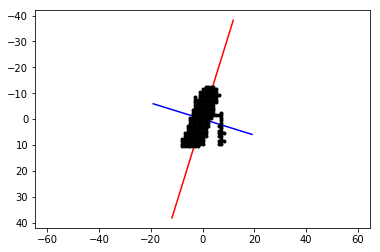

-17.22469488466689
255.0
0.0


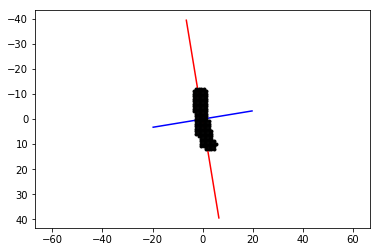

9.348158474872092
255.0
0.0


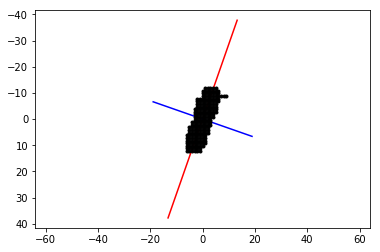

-19.268137344491617
255.0
0.0


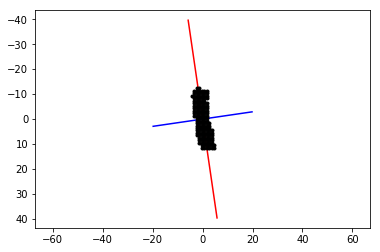

8.307478147028776
255.0
0.0


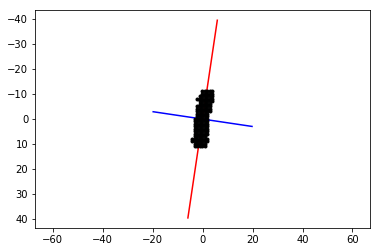

-8.459490084528172
255.0
0.0


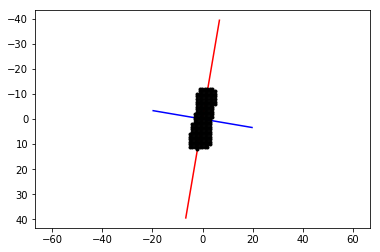

-9.657434369534363
255.0
0.0


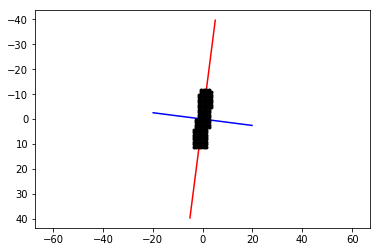

-7.298489103281247
255.0
0.0


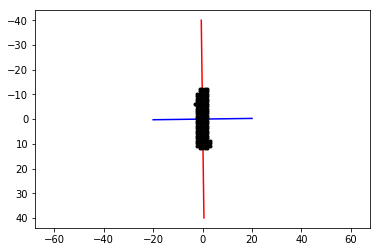

0.7704173713362993
255.0
0.0


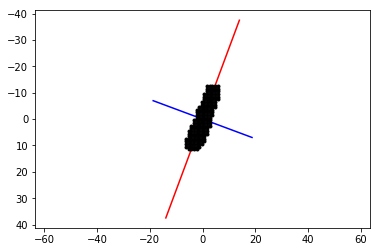

-20.409703997463534
255.0
0.0


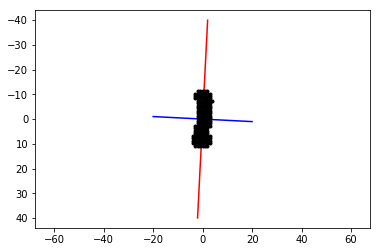

-2.915001300387739
255.0
0.0


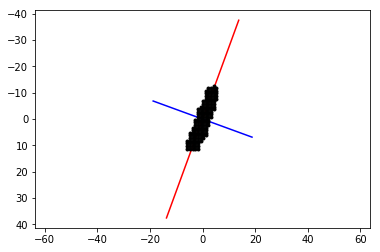

-20.074327355223275
255.0
0.0


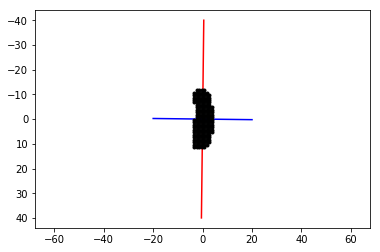

-0.6796737499976371
255.0
0.0


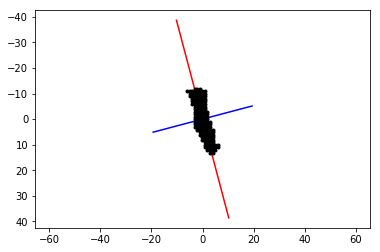

14.816180730138754
255.0
0.0


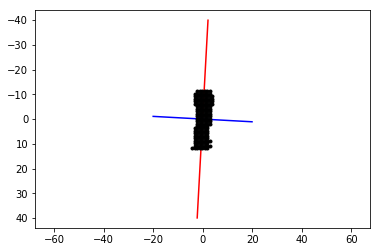

-3.126613394640652
255.0
0.0


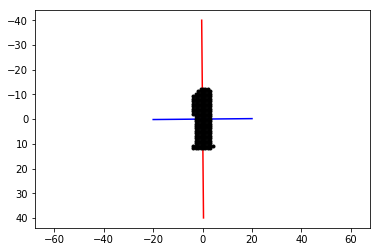

0.5291175576363928
255.0
0.0


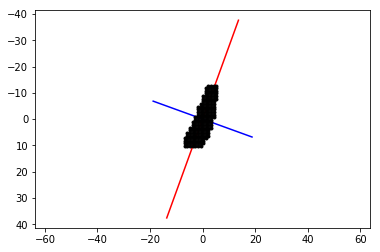

-19.93633242264897
255.0
0.0


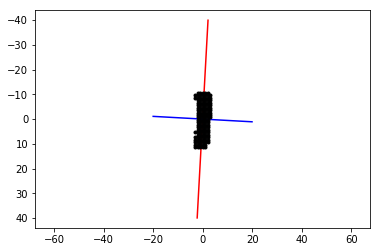

-3.136637533368343
255.0
0.0


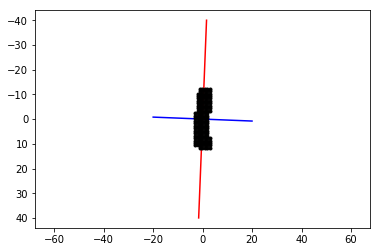

-2.280790738390843
255.0
0.0


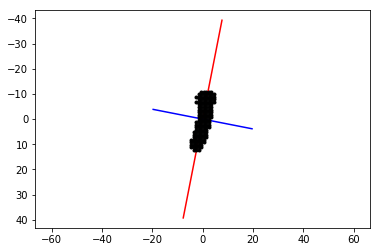

-11.086352328707434
255.0
0.0


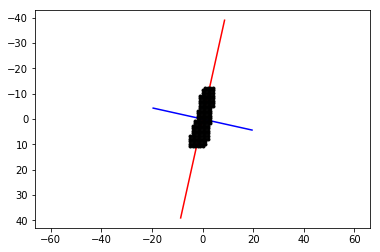

-12.519795987140721
255.0
0.0


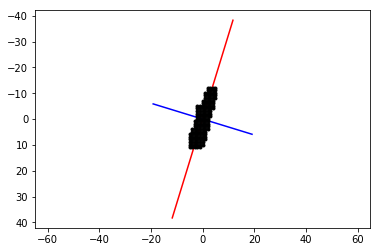

-17.066558540681456
255.0
0.0


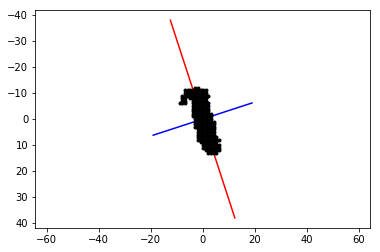

18.058807943181566
255.0
0.0


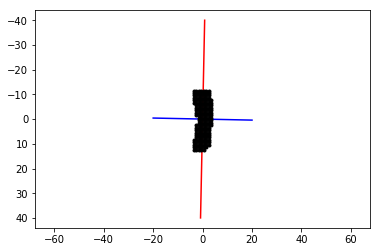

-1.1945727705451437
255.0
0.0


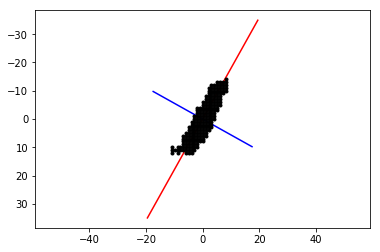

-29.178605798614193
255.0
0.0


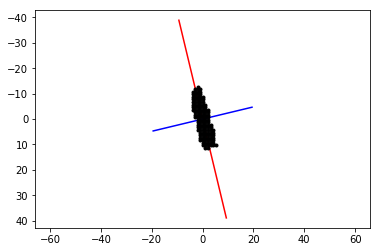

13.49307274526303
255.0
0.0


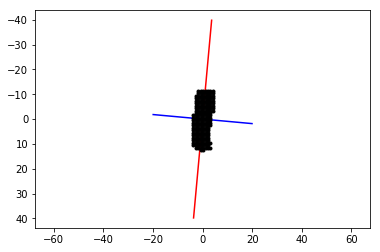

-5.222667706026327
255.0
0.0


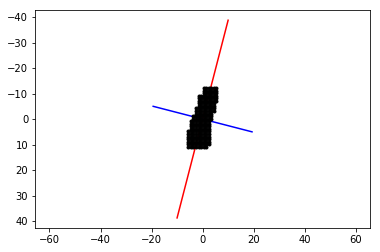

-14.47340898362135
255.0
0.0


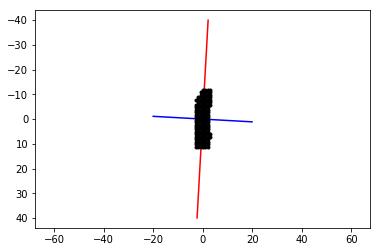

-3.1963864254384102
255.0
0.0


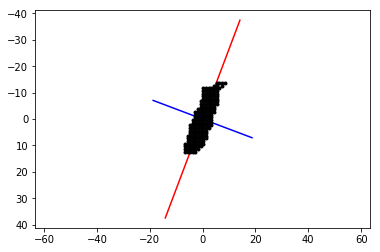

-20.679270771809897
255.0
0.0


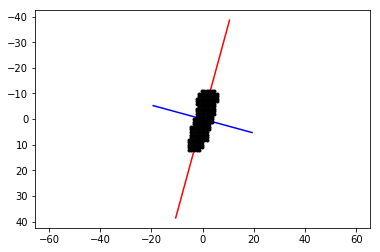

-15.2272967503595
255.0
0.0


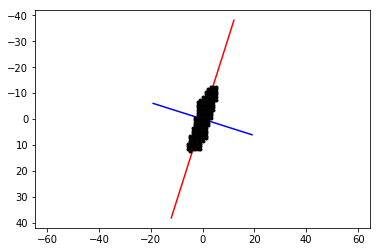

-17.58663478790658
255.0
0.0


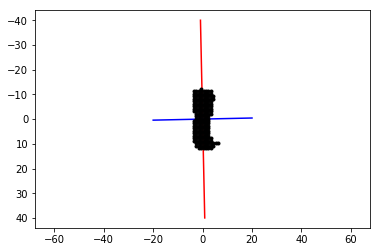

1.2374243057608425
255.0
0.0


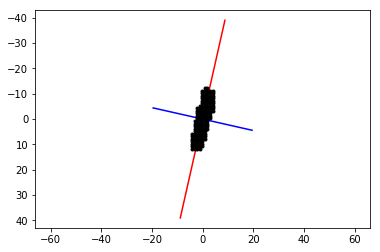

-12.725493057851843
255.0
0.0


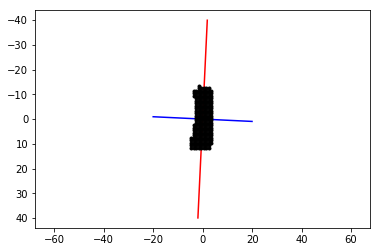

-2.714114485047234
255.0
0.0


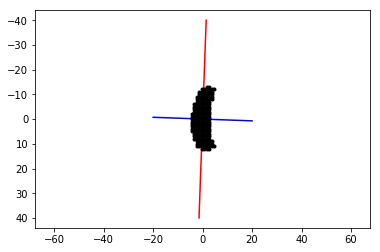

-2.0711550949540567
255.0
0.0


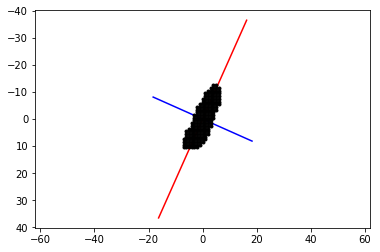

-24.0033794783618
255.0
0.0


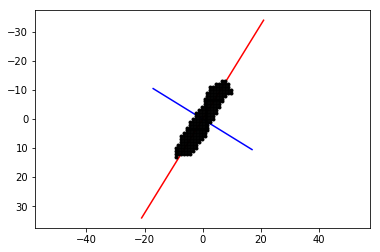

-31.669646266022202
255.0
0.0


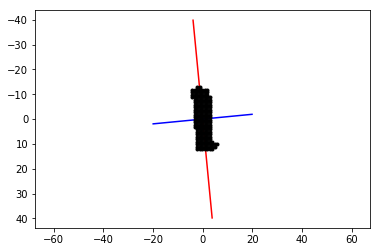

5.512696068746784
255.0
0.0


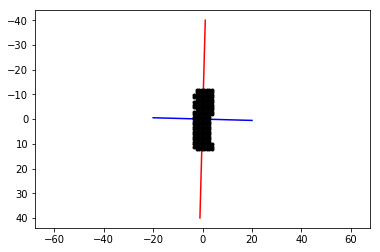

-1.5460043755629775
255.0
0.0


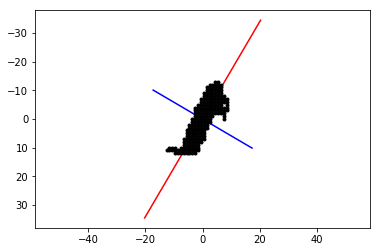

-30.38318769854438
255.0
0.0


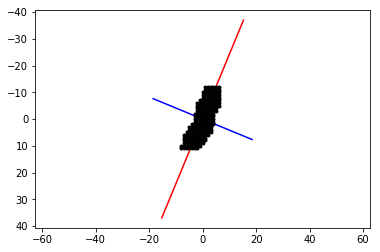

-22.4422545915521
255.0
0.0


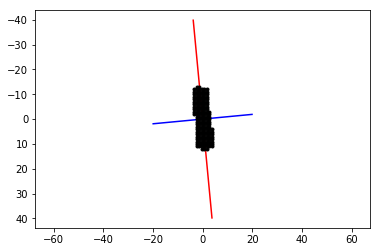

5.414611614367991
255.0
0.0


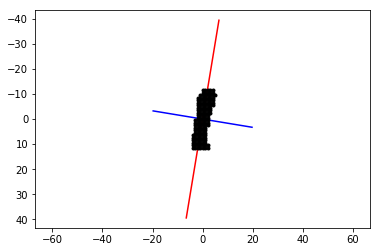

-9.382162750538
255.0
0.0


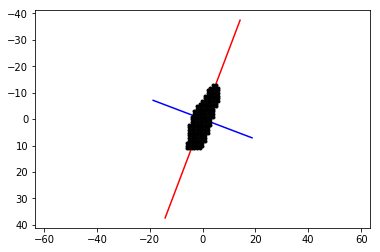

-20.763957704908467
255.0
0.0


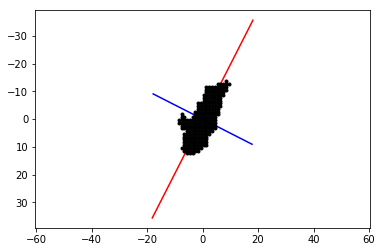

-26.978941506361227
255.0
0.0


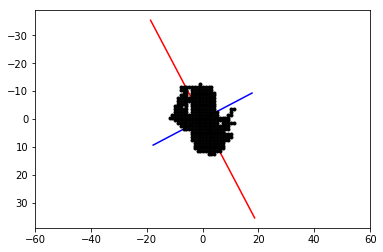

27.76642683253341
255.0
0.0


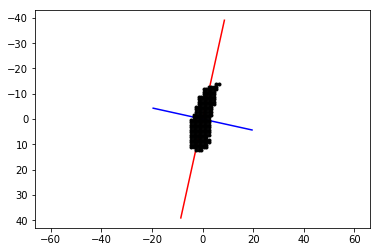

-12.430755146127204


In [14]:
show_result_ploting_images(1)

/home/zwu/miniconda3/envs/pytorch-py35/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


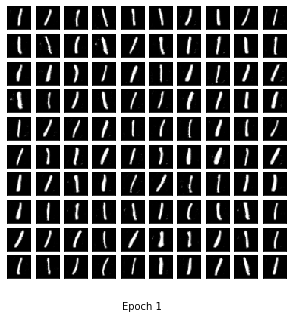

In [113]:
show_result(1)